In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from src.data_loader import load_and_align_prices
from src.stats import estimate_hedge_ratio, compute_spread
from src.strategy import (
    compute_zscore,
    generate_signals,
    position_from_signal,
    apply_volatility_scaling,
    apply_time_stop,
    apply_trade_filter,
    apply_capped_volatility_scaling
)
from src.backtester import backtest_pairs_strategy, calculate_performance_metrics

plt.style.use("seaborn-v0_8")


In [3]:
prices = load_and_align_prices(
    "../data/gold.csv",
    "../data/silver.csv"
)

with open("../results/statistical_summary.json", "r") as f:
    stats = json.load(f)

hedge_ratio = stats["hedge_ratio"]
half_life = stats["half_life_days"]

hedge_ratio, half_life


(0.8398666970367117, 69.69837286756666)

In [4]:
spread = prices["gold"] - hedge_ratio * prices["silver"]

In [5]:
z_window = int(half_life)  # ≈ 70
zscore = compute_zscore(spread, z_window)

In [6]:
entry_z = 2.0
exit_z = 0.5

signal = generate_signals(zscore, entry_z, exit_z)
position = position_from_signal(signal)

# position = apply_volatility_scaling(
#     position,
#     spread,
#     vol_window=z_window
# )

# position = apply_time_stop(
#     position,
#     max_holding_period=int(2 * half_life)
# )
# position = apply_trade_filter(
#     position,
#     spread,
#     vol_window=z_window,
#     quantile=0.9
# )

position = apply_capped_volatility_scaling(
    position,
    spread,
    vol_window=z_window,
    min_scale=0.5,
    max_scale=1.5
)


/Users/tanmaygarg/Desktop/gold_silver_strategy/src/strategy.py:47: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = signal.replace(to_replace=0, method="ffill")


In [7]:
transaction_cost = 0.0001

bt = backtest_pairs_strategy(
    prices,
    position,
    hedge_ratio,
    transaction_cost
)


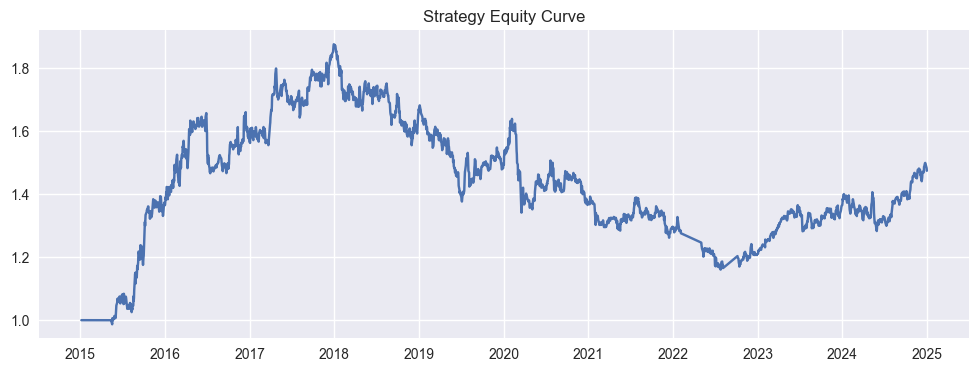

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(bt["equity_curve"])
plt.title("Strategy Equity Curve")
plt.savefig("../results/figures/equity_curve.png",
            dpi=300, bbox_inches="tight")

plt.show()


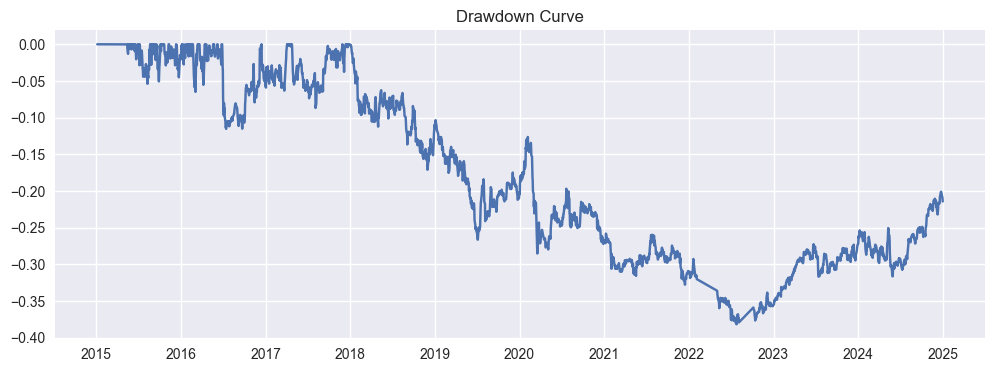

In [9]:
equity = bt["equity_curve"]
peak = equity.cummax()
drawdown = (equity - peak) / peak

plt.figure(figsize=(12, 4))
plt.plot(drawdown)
plt.title("Drawdown Curve")
plt.savefig("../results/figures/drawdown.png",
            dpi=300, bbox_inches="tight")

plt.show()


In [10]:
metrics = calculate_performance_metrics(
    bt["strategy_return"].dropna(),
    periods_per_year=252
)

metrics


{'Total Return': np.float64(0.4747489422179676),
 'Annualized Return': np.float64(0.040632486973328996),
 'Sharpe Ratio': np.float64(0.3219509913218485),
 'Max Drawdown': np.float64(-0.3815026189252653),
 'Calmar Ratio': np.float64(0.10650644309545021)}